In [1]:
#Initial Data Load () --Do not Remove
from google.colab import drive
drive.mount('/content/drive', force_remount = True)
! pip install -q kaggle
! mkdir ~/.kaggle
! cp /content/drive/MyDrive/Data/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c aptos2019-blindness-detection
! unzip aptos2019-blindness-detection

Streaming output truncated to the last 5000 lines.
  inflating: test_images/512beaada8f0.png  
  inflating: test_images/51323e9d2070.png  
  inflating: test_images/515675001b9e.png  
  inflating: test_images/515877da2def.png  
  inflating: test_images/5168ddccea88.png  
  inflating: test_images/5172c056a687.png  
  inflating: test_images/5177461f5339.png  
  inflating: test_images/51910bcb980d.png  
  inflating: test_images/51a3e9b6a1c0.png  
  inflating: test_images/51bbd82feec8.png  
  inflating: test_images/51de5fb8eccd.png  
  inflating: test_images/51e88694c81f.png  
  inflating: test_images/51f0bf8f1544.png  
  inflating: test_images/51f57fb32840.png  
  inflating: test_images/51fa42dc1415.png  
  inflating: test_images/5276ab33b7b0.png  
  inflating: test_images/52a353760f72.png  
  inflating: test_images/531937254e73.png  
  inflating: test_images/5325b1c22c61.png  
  inflating: test_images/53959e0a750b.png  
  inflating: test_images/53be22c72713.png  
  inflating: test_images/

In [ ]:
# Imported Libraries
import tensorflow as tf
from tensorflow import keras
from keras.layers import *
from keras import layers
from keras.models import Sequential, Model
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.applications import InceptionV3
from keras.models import load_model
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import shutil
import cv2
import os

In [ ]:
# Function to create folders and split data
def splitter(data, label):
  # Create Folders
  try:
    os.mkdir(label)
  except FileExistsError:
    pass
  names = ["NoDR", "Mild", "Moderate", "Severe", "ProliferativeDR"]
  for i in range(len(names)):
    try:
      os.mkdir(os.path.join(label, names[i]))
    except FileExistsError:
      pass

  # Splits Data
  identifier = {}
  # Sorts Data
  trainSortedData = data[data[:, 1].argsort()]
  # Identifies the unique value and stoes into identifier
  for i in np.unique(trainSortedData[:, 1]):
    identifier[i] = trainSortedData[trainSortedData[:, 1] == i]
  # Creates variable and stores names and data into its respective variables
    for i in identifier:
        name = names[int(i)]
        array = identifier[i]
  # Identifies and moves the images to respective folders
        for i in array:
            x = str(i[0]) + ".png"
            srcPath = os.path.join("train_images", x)
            dstPath = os.path.join(label, name, x)
            try:
              shutil.move(srcPath, dstPath)
            except FileNotFoundError:
              pass

In [ ]:
def predict(model, img_path):
    # Load image and preprocess it
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.
    
    # Make prediction
    prediction = model.predict(img_array)
    class_idx = np.argmax(prediction)
    class_labels = {0: 'NoDR', 1: 'Mild', 2: 'Moderate', 3: 'Severe', 4: 'ProliferativeDR'}
    predicted_class = class_labels[class_idx]
    
    return predicted_class

In [ ]:
# Initial Dataset
try:
  initialData = pd.read_csv("train.csv")
  initialData = np.array(initialData)
  usingData = initialData[:3600]
except FileNotFoundError:
  pass
# Split to Alien Dataset from Initial Dataset(last 62 rows)
alienData = np.array(initialData[3600:])
alienFolder = splitter(alienData, "alien")

# Split to Train Dataset from Initial Dataset(80%)
trainData = usingData[:(int)(len(usingData)*0.80), :]
trainFolder = splitter(trainData, "train")

# Split to Validation Dataset from Initial Dataset(20%)
validationData = usingData[(int)(len(usingData)*0.80):, :]
validationFolder = splitter(validationData, "validation")

In [ ]:
# Remove unused folders and data
! rm -rf sample_data/ test_images/ train_images/ aptos2019-blindness-detection.zip sample_submission.csv test.csv train.csv

In [ ]:
try:
  shutil.move('/content/alien', '/content/drive/MyDrive/Model')
except FileNotFoundError:
  pass

In [ ]:
# Parameters for Data Augmentation and Model
height = 224 # Image Height
width = 224 # Image Width

In [ ]:
# Data Augmentation on train folder
train_datagen = ImageDataGenerator (
                                    rescale = 1/255, # Rescaling images 0 to 1 also known as normalizing
                                    rotation_range = 10, # Range from 0 to 5 degress rotation (Can be both ways)
                                    zoom_range = 0.10, # Range from 0% to 5% to either Zoom In or Zoom Out
                                    horizontal_flip = True, # Horizontal flip needed not vertical
                                    
                                   )
train_generator = train_datagen.flow_from_directory (
                                                     '/content/train',
                                                     batch_size = 16, # Batch passing
                                                     class_mode = 'categorical', # categorical since multiple classes
                                                     target_size = (
                                                                    height, width # Resize
                                                                   )
                                                    )

Found 2880 images belonging to 5 classes.


/usr/local/lib/python3.9/dist-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


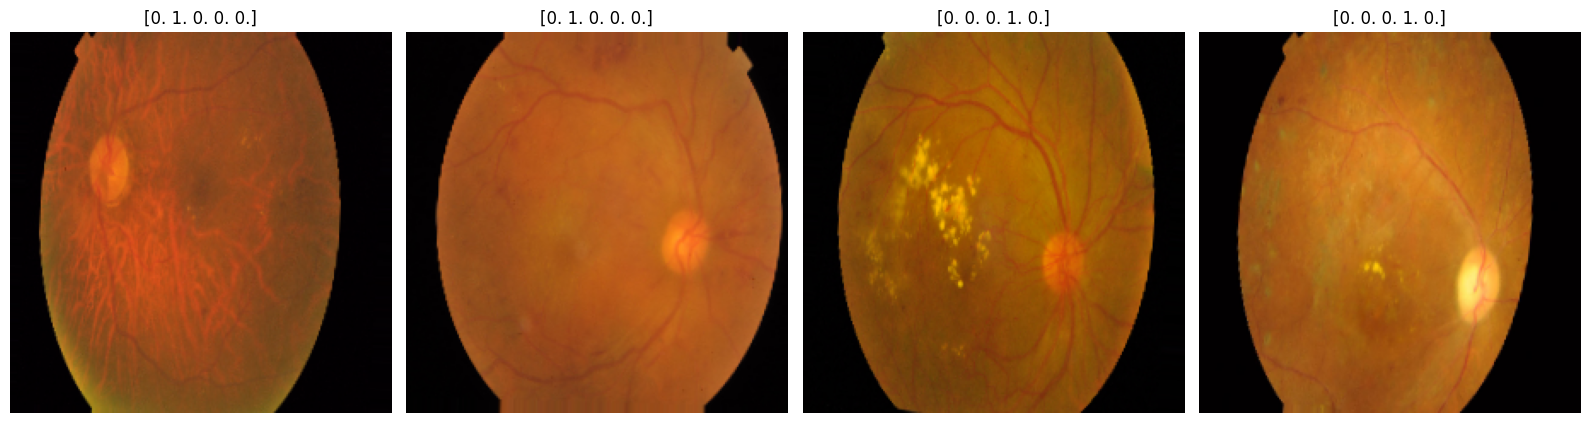

In [ ]:
# Generating Data Augmentation for display
images, labels = next(train_generator) # iteratting

# Plot in matrix
fig, axes = plt.subplots(1, 4, figsize=(16, 8))
axes = axes.ravel()

# Generating 5 images
for i in range(4):
    axes[i].imshow(images[i])
    axes[i].axis('off')
    axes[i].set_title(labels[i])

# Plotting
plt.tight_layout()
plt.show()

In [ ]:
# Validation generator from Validation folder (Dont need to proceed with Data Augmentation since its only for validation)
validation_generator = ImageDataGenerator().flow_from_directory (
                                                                 '/content/validation/',
                                                                 batch_size = 16,
                                                                 class_mode = 'categorical',
                                                                 target_size = (
                                                                                height,
                                                                                width
                                                                               )
                                                                )

Found 720 images belonging to 5 classes.


In [ ]:
# pretrainedModel = InceptionV3 (
#                                    weights = 'imagenet',
#                                    include_top = False, # Top layer is excluded
#                                    input_shape = ( # Input images 300 by 300 by 3 
#                                                   height,
#                                                   width, 
#                                                   3
#                                                  )
#                                   )

# # Keeping the weights same while training, so the pretrained model is not affected
# for layer in pretrainedModel.layers:
#   layer.trainable = False
pretrainedModel = tf.keras.applications.InceptionV3(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrainedModel.trainable = False

87910968/87910968 [==============================] - 5s 0us/step


In [ ]:
inputs = pretrainedModel.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrainedModel.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(5s, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

opt = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(
    optimizer= opt,
    loss='categorical_crossentropy',
    metrics=['accuracy','AUC']
)

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    batch_size = 16,
    epochs=5,
)
# Add new classification layers on top of the base model
# model = Sequential (
#                     [
#                         pretrainedModel,
#                         GlobalAveragePooling2D(),
#                         Dropout(0.5),
#                         Dense(5, activation='softmax')
                    #  pretrainedModel,
                    #  Conv2D(50, 3 , activation ='relu'),
                    #  Conv2D(25, 3 , activation ='relu'),
                    #  Flatten(),
                    #  Dense(60, activation = 'relu'),
                    #  Dense(5, activation = 'softmax')
                    #  GlobalAveragePooling2D(),
                    #  Dense (
                    #         512,
                    #         activation='relu'
                    #        ),
                    #  Dropout (
                    #           0.5
                    #          ),
                    #  Dense (
                    #         256,
                    #         activation='relu'
                    #        ),
                    #  Dropout (
                    #           0.5
                    #          ),
                    #  Dense (
                    #         5,
                    #         activation='softmax'
                    #        )
                  #    ]
                  #  )
model.summary();

Epoch 1/5
180/180 [==============================] - 462s 2s/step - loss: 0.8775 - accuracy: 0.6861 - auc: 0.9033 - val_loss: 12.2212 - val_accuracy: 0.5139 - val_auc: 0.6998
Epoch 2/5
180/180 [==============================] - 441s 2s/step - loss: 0.7283 - accuracy: 0.7253 - auc: 0.9330 - val_loss: 8.8834 - val_accuracy: 0.4944 - val_auc: 0.7212
Epoch 3/5
180/180 [==============================] - 439s 2s/step - loss: 0.7023 - accuracy: 0.7316 - auc: 0.9377 - val_loss: 9.3213 - val_accuracy: 0.3819 - val_auc: 0.6427
Epoch 4/5
180/180 [==============================] - 448s 2s/step - loss: 0.6715 - accuracy: 0.7451 - auc: 0.9427 - val_loss: 9.0546 - val_accuracy: 0.3708 - val_auc: 0.6360
Epoch 5/5
180/180 [==============================] - 449s 2s/step - loss: 0.6490 - accuracy: 0.7580 - auc: 0.9468 - val_loss: 11.0802 - val_accuracy: 0.2625 - val_auc: 0.5548
Model: "model"
__________________________________________________________________________________________________
 Layer (type) 

In [ ]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    batch_size = 16,
    epochs=10,
)

NameError: ignored

In [ ]:
model.save('/content/drive/MyDrive/Model/Final51.h5')

NameError: ignored

In [ ]:
model2 = Sequential (
                    [
                     pretrainedModel,
                     Conv2D(500, 3 , activation ='relu'),
                     Conv2D(250, 3 , activation ='relu'),
                    Dense(195, activation = 'relu'),
                     Flatten(),
                     
                     Dense(60, activation = 'relu'),
                     Dense(5, activation = 'softmax')
                  
                     ]
                   )
model2.summary();
model2.compile (
               optimizer = Adam (
                                 learning_rate = 0.0001
                                ),
               loss = 'categorical_crossentropy',
               metrics = [
                          'accuracy'
                         ]
              )
history2 = model.fit (
                     train_generator,
                     epochs = 2,
                     validation_data = validation_generator
                    )

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 conv2d_594 (Conv2D)         (None, 3, 3, 500)         9216500   
                                                                 
 conv2d_595 (Conv2D)         (None, 1, 1, 250)         1125250   
                                                                 
 dense_40 (Dense)            (None, 1, 1, 195)         48945     
                                                                 
 flatten_16 (Flatten)        (None, 195)               0         
                                                                 
 dense_41 (Dense)            (None, 60)                11760     
                                                                 
 dense_42 (Dense)            (None, 5)               

RuntimeError: ignored

In [ ]:
model.fit (
                     train_generator,
                     epochs = 2,
                     validation_data = validation_generator
                    )

Epoch 1/2
720/720 [==============================] - 591s 812ms/step - loss: 1.3802 - accuracy: 0.5104 - val_loss: 11.6145 - val_accuracy: 0.1222
Epoch 2/2
720/720 [==============================] - 536s 744ms/step - loss: 1.0720 - accuracy: 0.6208 - val_loss: 11.7521 - val_accuracy: 0.1597


In [ ]:
# Compile the model
model.compile (
               optimizer = Adam (
                                 learning_rate = 0.0001
                                ),
               loss = 'categorical_crossentropy',
               metrics = [
                          'accuracy'
                         ]
              )

In [ ]:
# Train the model
history = model.fit (
                     train_generator,
                     epochs = 5,
                     validation_data = validation_generator
                    )

Epoch 1/5
720/720 [==============================] - 591s 815ms/step - loss: 0.8822 - accuracy: 0.6934 - val_loss: 5.4807 - val_accuracy: 0.3292
Epoch 2/5
720/720 [==============================] - 582s 808ms/step - loss: 0.7012 - accuracy: 0.7361 - val_loss: 7.5744 - val_accuracy: 0.4250
Epoch 3/5
720/720 [==============================] - 581s 806ms/step - loss: 0.6405 - accuracy: 0.7535 - val_loss: 11.2327 - val_accuracy: 0.2792
Epoch 4/5
720/720 [==============================] - 583s 810ms/step - loss: 0.5915 - accuracy: 0.7698 - val_loss: 8.4075 - val_accuracy: 0.3250
Epoch 5/5
720/720 [==============================] - 584s 811ms/step - loss: 0.5755 - accuracy: 0.7830 - val_loss: 12.1451 - val_accuracy: 0.2986


In [ ]:
# Save the Model
model.save('/content/drive/MyDrive/Model/secondTest3.h5')

In [ ]:
model = load_model('/content/drive/MyDrive/Model/secondTest3.h5')

In [ ]:
predicted_class = predict(model, '/content/alien/Mild/fe674c2f73f5.png')
print(predicted_class)

1/1 [==============================] - 0s 100ms/step
Moderate
